# Machine Learning Model for Efficiency in Gold Mining

## Project Overview

In [1]:
# Import Standard Libraries
import warnings

# Import Third Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Explore Data

In [2]:
def load_data(file_name):
    try: # Try to load the data locally from the data folder
        data = pd.read_csv(f'data/{file_name}')
    except: # Read the data from the TripTen Hub
        data = pd.read_csv(f'/datasets/{file_name}')
    
    return data

In [3]:
# Load the data
data_full = load_data('gold_recovery_full.csv')
data_train = load_data('gold_recovery_train.csv')
data_test = load_data('gold_recovery_test.csv')

# Name the dataframes
data_full.name = 'data_full'
data_train.name = 'data_train'
data_test.name = 'data_test'

In [4]:
# Define the data sets
data_sets = [data_full, data_train, data_test]

# Define the target columns
target_cols = ['rougher.output.recovery', 'final.output.recovery']

In [5]:
print(f"Train Data as a percentage of Full Data: {data_train.shape[0] / data_full.shape[0]:.2%}")
print(f"Test Data as a percentage of Full Data: {data_test.shape[0] / data_full.shape[0]:.2%}")

Train Data as a percentage of Full Data: 74.22%
Test Data as a percentage of Full Data: 25.78%


### Check that recovery is calculated correctly.  
Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

Recovery = (share of gold in the concentrate right after flotation * (share of gold in the feed before flotation - share of gold in the rougher tails right after flotation)) /
(share of gold in feed before flotation * (share of gold in concentrate right after flotation - share of gold in the rougher tails right after floatation))  
\* 100

--------
Recovery = (rougher.output.concentrate_au * (rougher.input.feed_au - rougher.output.tail_au)) /  
(rougher.input.feed_au * (rougher.output.concentrate_au - rougher.output.tail_au))  
\* 100

In [6]:
def calc_rough_recovery(row):

    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    if (F*(C-T)) == 0:
        recovery = 0
    else:
        recovery = ((C*(F-T))/(F*(C-T)))*100

    return recovery

In [7]:
def compare_rough_recovery(df):
    
    # Narrow the df to the necessary columns
    df = df[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']]
    
    # Drop rows with NaN values because we can only calculate and compare the recovery if we have all the necessary values
    df = df.dropna()
    
    # Calculate the recovery
    df.loc[:, 'calculated_recovery'] = df.apply(calc_rough_recovery, axis=1)
    
    # Calculate the mean absolute error
    mae = np.abs(df['rougher.output.recovery'] - df['calculated_recovery']).mean()
    
    return mae


In [8]:
print(f'The MAE for the rougher.output.recovery column in the {data_train.name} dataframe is {compare_rough_recovery(data_train)}')

The MAE for the rougher.output.recovery column in the data_train dataframe is 9.210911277458828e-15


The MAE between the recorded value for rougher.output.recovery and the calculated amount is very small, therefore we can trust values in this column.

### Analyze the features not available in the test set.
What are these parameters?  
What is their type?

In [9]:
# Print column count for each dataset
for df in data_sets:
    print(f'{df.name} column count: {len(df.columns)}')

data_full column count: 87
data_train column count: 87
data_test column count: 53


The test dataset is missing 34 columns.

In [10]:
# Assert that the full and train datasets have the same columns
assert data_full.columns.tolist() == data_train.columns.tolist()

# Assert that data_full has the same number of rows as data_train + data_test
assert data_full.shape[0] == data_train.shape[0] + data_test.shape[0]

In [11]:
# Find the columns that are missing in the test dataset
missing_cols = data_train.columns.difference(data_test.columns).tolist()

# Print the types of the columns that are missing in the test dataset
for col in missing_cols:
    print(f'{col} type: {data_train[col].dtype}')

final.output.concentrate_ag type: float64
final.output.concentrate_au type: float64
final.output.concentrate_pb type: float64
final.output.concentrate_sol type: float64
final.output.recovery type: float64
final.output.tail_ag type: float64
final.output.tail_au type: float64
final.output.tail_pb type: float64
final.output.tail_sol type: float64
primary_cleaner.output.concentrate_ag type: float64
primary_cleaner.output.concentrate_au type: float64
primary_cleaner.output.concentrate_pb type: float64
primary_cleaner.output.concentrate_sol type: float64
primary_cleaner.output.tail_ag type: float64
primary_cleaner.output.tail_au type: float64
primary_cleaner.output.tail_pb type: float64
primary_cleaner.output.tail_sol type: float64
rougher.calculation.au_pb_ratio type: float64
rougher.calculation.floatbank10_sulfate_to_au_feed type: float64
rougher.calculation.floatbank11_sulfate_to_au_feed type: float64
rougher.calculation.sulfate_to_au_concentrate type: float64
rougher.output.concentrate_a

In addition to the expected missing target values (rougher.output.recovery and final.output.recovery), the test data set is missing 32 other columns. These values are not known at the time of prediction, and should therefor be dropped from the training data set.

### Missing Values

In [12]:
# print missing value count for each data set
for df in data_sets:
    print(f'{df.name} missing value count:')
    print(df.isnull().sum().sum())

data_full missing value count:
36587
data_train missing value count:
30320
data_test missing value count:
2360


In [13]:
# Print the percentage of missing values for each column in the two data subsets
pd.set_option('display.max_rows', None)
for df in data_sets[1:]:
    print(f'{df.name} missing value percentage:')
    print(df.isnull().mean()*100)
    print()
    
pd.set_option('display.max_rows', 10)

data_train missing value percentage:
date                                                   0.000000
final.output.concentrate_ag                            0.427046
final.output.concentrate_pb                            0.427046
final.output.concentrate_sol                           2.194543
final.output.concentrate_au                            0.421115
final.output.recovery                                  9.021352
final.output.tail_ag                                   0.391459
final.output.tail_pb                                   1.085409
final.output.tail_sol                                  0.860024
final.output.tail_au                                   0.391459
primary_cleaner.input.sulfate                          7.752076
primary_cleaner.input.depressant                       7.485172
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         5.842230
primary_cleaner.output.concentrate_ag                  0.486358
pri

In [14]:
# Get percent of rows with NaN values in any column for the two data subsets
for df in data_sets[1:]:
    print(f'{df.name} rows with NaN values: {df.isnull().any(axis=1).mean()*100:.2f}%')

data_train rows with NaN values: 34.66%
data_test rows with NaN values: 8.08%


In [15]:
# Print percent of rows with NaN values in target columns in the full dataset
print(f'{data_full.name} rows with NaN values in target columns: {data_full[target_cols].isnull().any(axis=1).mean()*100:.2f}%')

data_full rows with NaN values in target columns: 14.43%


There are significant percentages of missing values across both axises. Dropping nearly 35% of rows in the training data is clearly not a viable option. Dropping columns is also not an ideal solution, since we want as many features as possible for prediction (and we would still have plenty of rows with missing values). Thankfully, we know from the project description that "Parameters that are next to each other in terms of time are often similar.", therefor we can forward fill missing feature values. We will, however, have to drop rows with missing values in either target, which accounts for about 14% of the total data (we want to train our model only on actual results).

## Data Preprocessing

Based on the discoveries from exploring the data, the following steps will be taken to preprocess the data for the task at hand:

1. Drop rows where either target is missing from full dataset.
2. Be sure full dataset is organized by date, then forward fill missing values (because "Parameters that are next to each other in terms of time are often similar."). Check no missing values.
3. Redefine the test df and train df as inner merge on date with full data set, drop necessary columns

In [16]:
# Drop rows with NaN values in the target columns
data_full = data_full.dropna(subset=target_cols)

# Sort full dataset by date
data_full = data_full.sort_values('date')
# Forward fill the missing values
data_full = data_full.fillna(method='ffill')
# Assert no missing values
assert data_full.isnull().sum().sum() == 0


# Define the drop columns
drop_cols = [col for col in missing_cols if col not in target_cols]

# Redefine the train data set as inner join of train dates and full data
data_train_dates = data_train['date'].to_frame()
data_train = data_train_dates.merge(data_full, on='date', how='inner')
# Drop the drop columns
data_train = data_train.drop(drop_cols, axis=1)

# Redefine the test data set as inner join of test dates and full data
data_test_dates = data_test['date'].to_frame()
data_test = data_test_dates.merge(data_full, on='date', how='inner')
# Drop the drop columns and target columns
data_test = data_test.drop(drop_cols + target_cols, axis=1)

# Assert no missing values in the subsets
assert data_train.isnull().sum().sum() == 0
assert data_test.isnull().sum().sum() == 0

# Assert the data_test columns equal the data_train columns minus the target columns
assert data_test.columns.tolist() == data_train.drop(target_cols, axis=1).columns.tolist()

# Assert the data_full rows equal the data_train rows plus the data_test rows
assert data_full.shape[0] == data_train.shape[0] + data_test.shape[0]

# Name the dataframes
data_full.name = 'data_full'
data_train.name = 'data_train'
data_test.name = 'data_test'

data_sets = [data_full, data_train, data_test]

In [17]:
# Print the shapes of the data sets
for data in data_sets:
    print(f'{data.name} shape: {data.shape}')

data_full shape: (19439, 87)
data_train shape: (14149, 55)
data_test shape: (5290, 53)


In [18]:
print(f"Train Data as percentage of Full Data: {data_train.shape[0]/data_full.shape[0]*100:.2f}%")
print(f"Test Data as percentage of Full Data: {data_test.shape[0]/data_full.shape[0]*100:.2f}%")

Train Data as percentage of Full Data: 72.79%
Test Data as percentage of Full Data: 27.21%


After preprocessing the data, the share of train data to test data is withing 2% of the original share and remains an appropriate split.

## Analyze the Data

In [19]:
# Print the min and max date for each dataset
for df in data_sets:
    print(f'{df.name} min date: {df["date"].min()}, max date: {df["date"].max()}')

data_full min date: 2016-01-15 00:00:00, max date: 2018-08-18 10:59:59
data_train min date: 2016-01-15 00:00:00, max date: 2018-08-18 10:59:59
data_test min date: 2016-09-01 00:59:59, max date: 2017-12-31 23:59:59


### Concentrations of metals (Au, Ag, Pb) per purification stage.

In [20]:
def sort_metal_concentration_columns():
    # Make list of metal concentration columns
    metals = ['au', 'ag', 'pb']
    metal_cols = [col for col in data_full.columns if any(".concentrate_" + metal in col for metal in metals)]

# Define order of metals and stages
    metal_order = {'au': 1, 'ag': 2, 'pb': 3}
    stage_order = {'rougher': 1, 'primary_cleaner': 2, 'final': 3}

# Sort the columns based on metal and stage
    sorted_metal_cols = sorted(
    metal_cols,
    key=lambda col: (
        metal_order[col.split('_')[-1]],  # metal order
        stage_order[col.split('.')[0]],  # stage order 
    )
)

    return sorted_metal_cols

metal_cols = sort_metal_concentration_columns()

print(metal_cols)

['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']


In [21]:
def plot_metal_concentration(data, metal_cols, metal):
    # Narrow list of columns to the metal of interest
    metal_cols = [col for col in metal_cols if metal in col]
    
    # Set the figure size
    fig = plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    
    # hist plot with density of the metal concentration columns
    for col in metal_cols:
        sns.histplot(data[col], kde=True, stat="density", label=col)
    
    # Set the title
    plt.title(f'{metal.upper()} Concentration per Stage')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')  # Set the legend outside of the plot
    
    # Set x-axis min to 0
    plt.xlim(0, None)
    # Set x-axis label
    plt.xlabel('Concentration')
    
    return fig  # Return the figure object

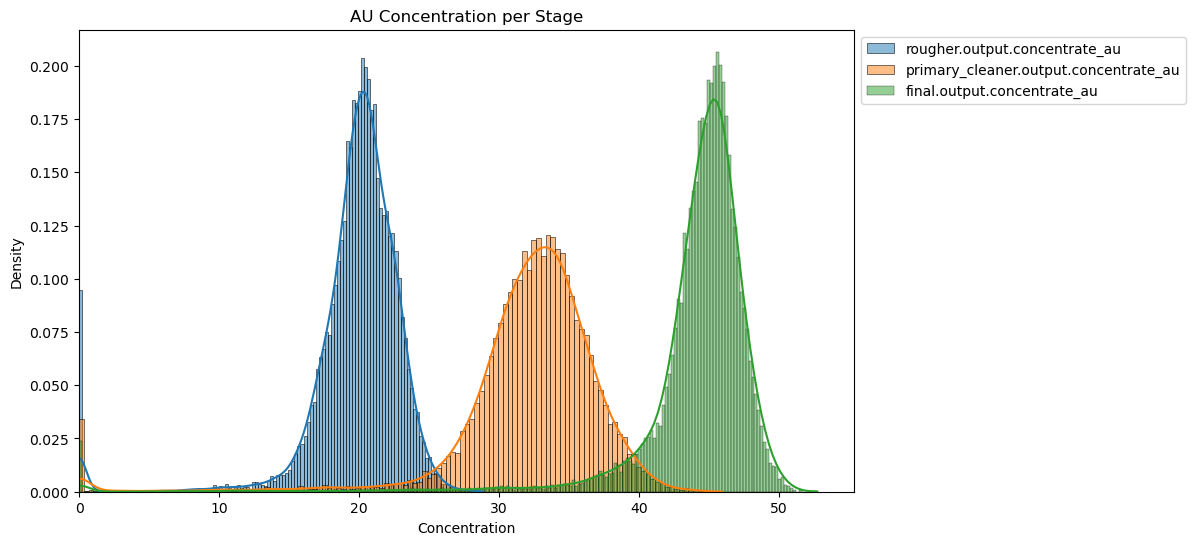

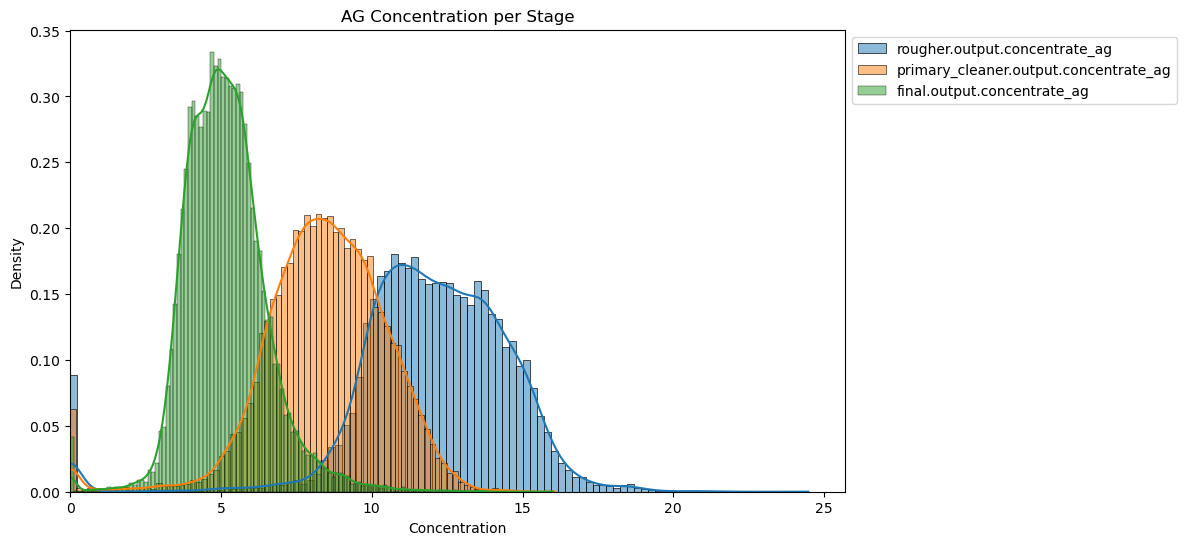

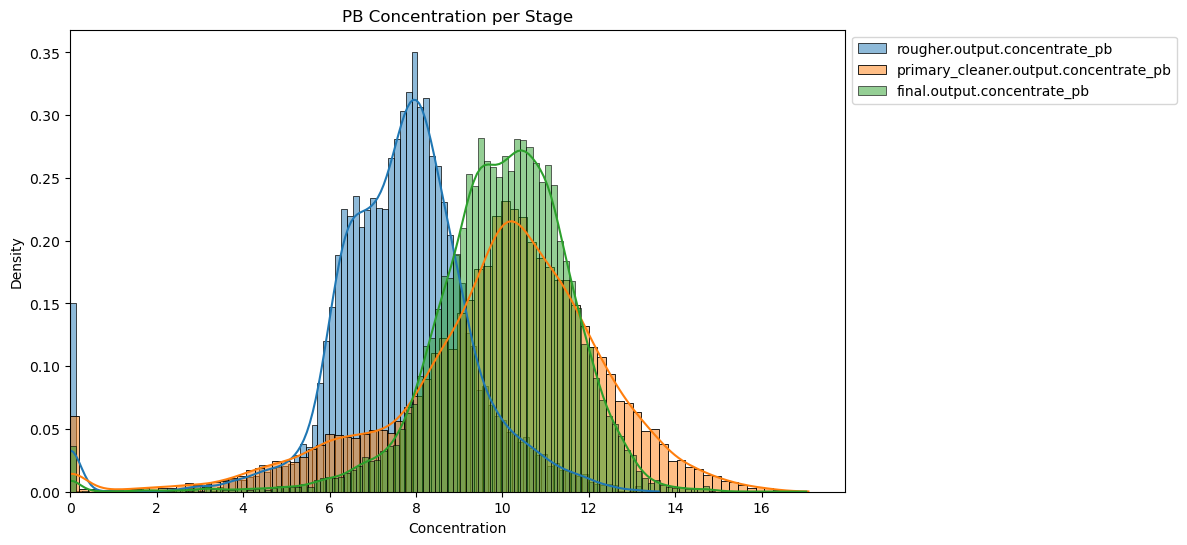

In [23]:
plot_metal_concentration(data_full, metal_cols, 'au')
plot_metal_concentration(data_full, metal_cols, 'ag')
plot_metal_concentration(data_full, metal_cols, 'pb');